## Code to process the collected data and present results

Import all necessary libraries.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

Read the articulation_angle_log.csv and convet the timestamp in nano seconds to datetime format.

In [4]:
scenario = '5'
test = '5'

# Set up the directory structure
directory = f'Tests/Scenario {scenario}/Test{test}/'

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Load the data
file_path = f'articulation_angle_log.csv'
df = pd.read_csv(file_path)

df.to_csv(f'{directory}articulation_angle_log.csv')

# Ensure that timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

Create sub dataframes of each method for easy visualisation

In [5]:
# Create datasets
df_ground_truth = df[['timestamp', 'ground_truth']].dropna(subset=['ground_truth'])
df_marker = df[['timestamp', 'markers']].dropna(subset=['markers'])
df_range = df[['timestamp', 'range']].dropna(subset=['range'])
df_filtered = df[['timestamp', 'filtered']].dropna(subset=['filtered'])

# Convert to NumPy arrays explicitly for plotting
timestamps_gt = df_ground_truth['timestamp'].to_numpy()
ground_truth_values = df_ground_truth['ground_truth'].to_numpy()

timestamps_marker = df_marker['timestamp'].to_numpy()
markers_values = df_marker['markers'].to_numpy()

timestamps_range = df_range['timestamp'].to_numpy()
range_values = df_range['range'].to_numpy()

timestamps_filtered = df_filtered['timestamp'].to_numpy()
filtered_values = df_filtered['filtered'].to_numpy()

### Plot for Ground Truth and Markers over Time

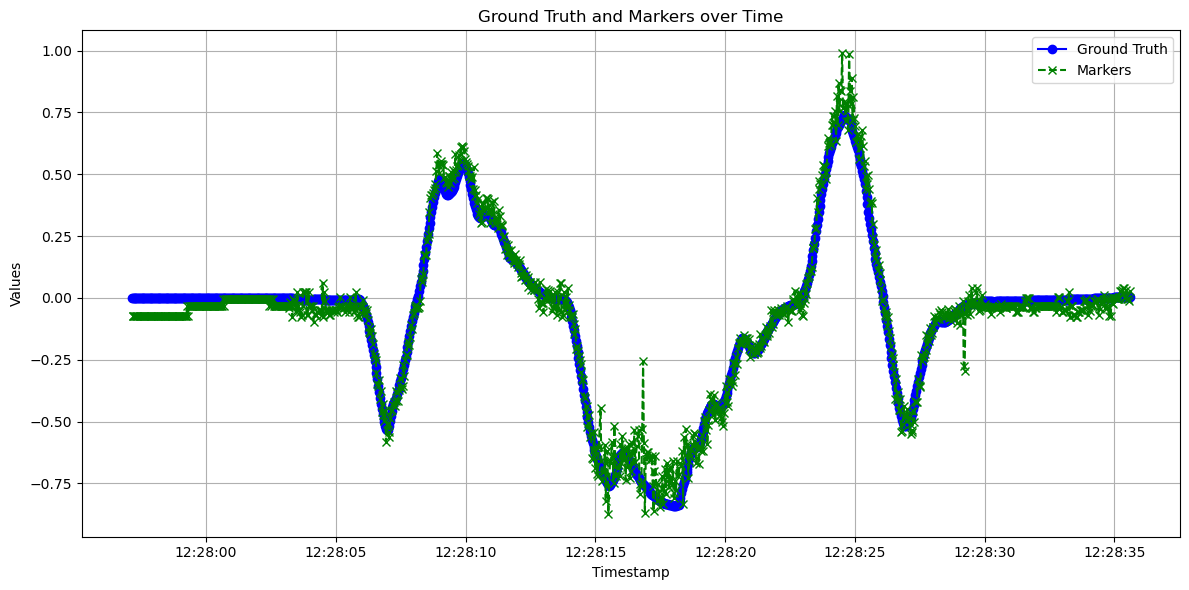

In [6]:
# Plot 1: Timestamp vs Ground Truth and Marker
plt.figure(figsize=(12, 6))
plt.plot(timestamps_gt, ground_truth_values, label='Ground Truth', marker='o', linestyle='-', color='blue')
plt.plot(timestamps_marker, markers_values, label='Markers', marker='x', linestyle='--', color='green')

plt.title('Ground Truth and Markers over Time')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{directory}gvm', format='png')
plt.show()

### Plot for Ground Truth and Range over Time

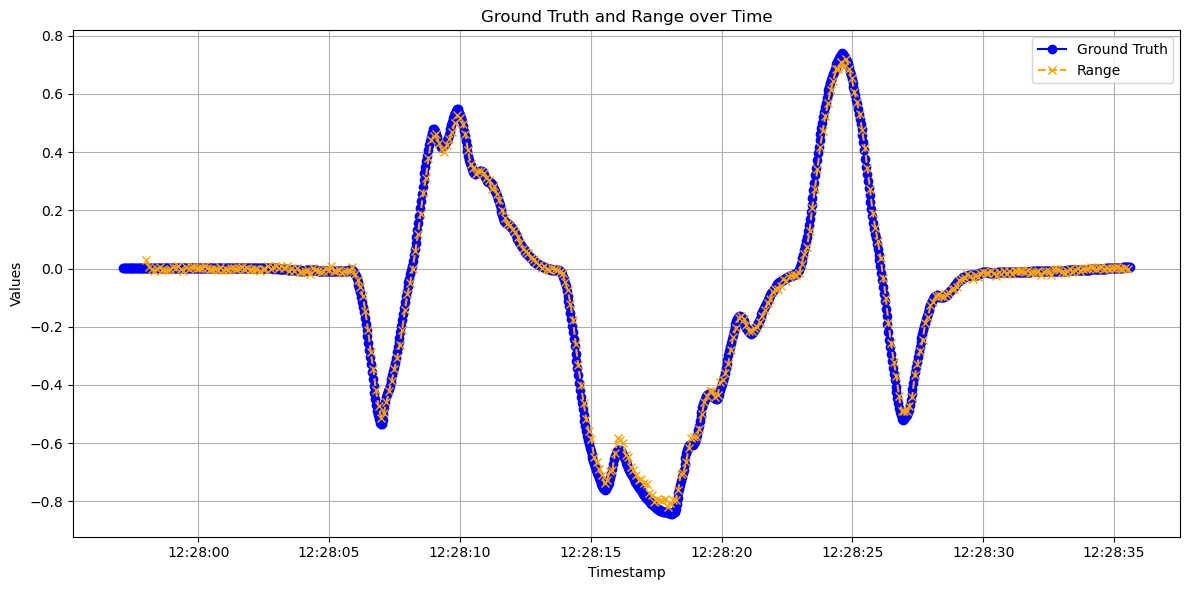

In [7]:
# Plot 2: Timestamp vs Ground Truth and Range
plt.figure(figsize=(12, 6))
plt.plot(timestamps_gt, ground_truth_values, label='Ground Truth', marker='o', linestyle='-', color='blue')
plt.plot(timestamps_range, range_values, label='Range', marker='x', linestyle='--', color='orange')

plt.title('Ground Truth and Range over Time')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{directory}gvr', format='png')
plt.show()

### Plot for Ground Truth and Filtered over Time

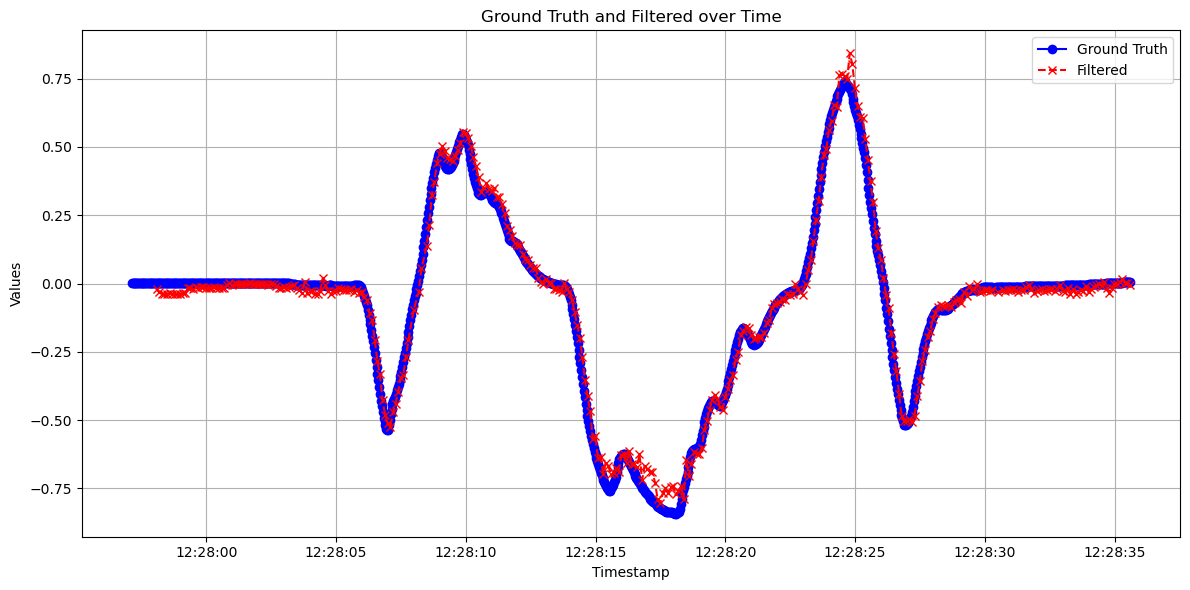

In [8]:
# Plot 3: Timestamp vs Ground Truth and Filtered
plt.figure(figsize=(12, 6))
plt.plot(timestamps_gt, ground_truth_values, label='Ground Truth', marker='o', linestyle='-', color='blue')
plt.plot(timestamps_filtered, filtered_values, label='Filtered', marker='x', linestyle='--', color='red')

plt.title('Ground Truth and Filtered over Time')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{directory}gvk', format='png')
plt.show()

### Downsampling and performance evaluation

In [9]:
# Load the data
file_path = 'articulation_angle_log.csv'
data = pd.read_csv(file_path)

# Convert timestamp to datetime for easier manipulation
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# Resample the data to 100 millisecond intervals, computing the mean for each interval
resampled_data = data.resample('100ms', on='timestamp').mean()

# Dropping rows where the ground truth is missing
resampled_data = resampled_data.dropna(subset=['ground_truth'])

# Apply forward fill to other columns (markers, range, filtered)
resampled_data = resampled_data.ffill()

# Drop any remaining rows with NaN values (which may appear if there was no valid data to forward fill)
resampled_data = resampled_data.dropna()

# Save the processed data to a new CSV file
resampled_data.to_csv(f'{directory}aggregated_data.csv')

# Calculate MAE and RMSE for each column against the ground truth
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    return mae, rmse

# Calculate metrics for 'markers'
mae_markers, rmse_markers = calculate_metrics(resampled_data['ground_truth'], resampled_data['markers'])

# Calculate metrics for 'range'
mae_range, rmse_range = calculate_metrics(resampled_data['ground_truth'], resampled_data['range'])

# Calculate metrics for 'filtered'
mae_filtered, rmse_filtered = calculate_metrics(resampled_data['ground_truth'], resampled_data['filtered'])

# Writing results to a txt file
with open(f'{directory}metrics_results.txt', 'w') as file:
    file.write(f"{mae_markers}, {mae_range}, {mae_filtered}, {rmse_markers}, {rmse_range}, {rmse_filtered}")


# Display the results
print(f"MAE for Markers: {mae_markers:.4f}, RMSE for Markers: {rmse_markers:.4f}")
print(f"MAE for Range: {mae_range:.4f}, RMSE for Range: {rmse_range:.4f}")
print(f"MAE for Filtered: {mae_filtered:.4f}, RMSE for Filtered: {rmse_filtered:.4f}")

MAE for Markers: 0.0334, RMSE for Markers: 0.0477
MAE for Range: 0.0124, RMSE for Range: 0.0182
MAE for Filtered: 0.0212, RMSE for Filtered: 0.0294


### Measure the delay in calculation for each method.

In [10]:
# Load the CSV file into a pandas DataFrame
delay_log = pd.read_csv('delay_log.csv')

# Calculate the mean of each column, ignoring missing values (NaN)
mean_markers = delay_log['markers'].mean()
mean_range = delay_log['range'].mean()
mean_filtered = delay_log['filtered'].mean()

# Print the results
print(f"Mean delay of 'markers' method: {mean_markers} sec")
print(f"Mean delay of 'range' method: {mean_range} sec")
print(f"Mean delay of Kalman filter: {mean_filtered} sec")

Mean delay of 'markers' method: 0.004879807091055861 sec
Mean delay of 'range' method: 0.05228595165391039 sec
Mean delay of Kalman filter: 0.08291603612899777 sec


###  Box plot comparing the distributions of ground truth, marker, range, and filtered data:

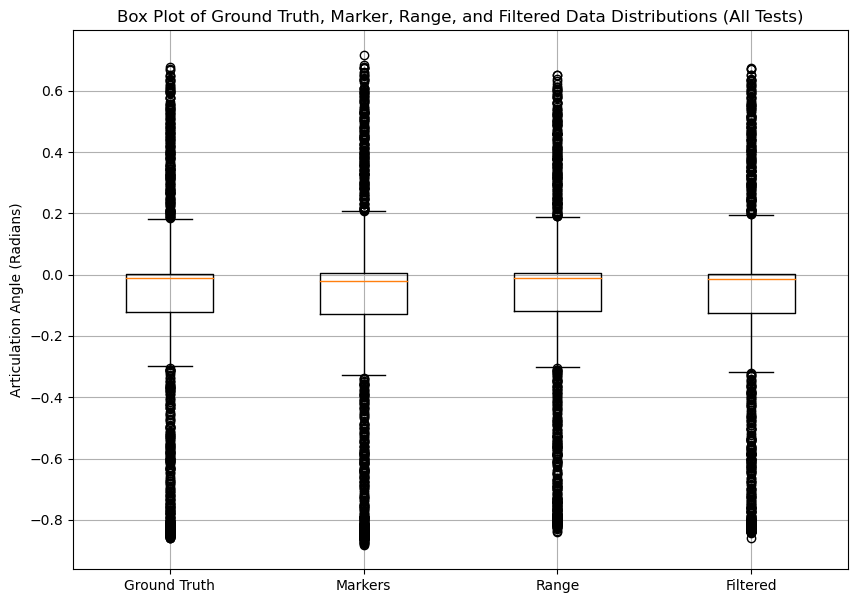

In [27]:
# Initialize an empty list to store data from all tests
all_data = []

# Define the number of scenarios and tests
scenario = 1  # Update this based on your specific scenarios
num_tests = 5  # Assuming there are 5 tests per scenario

# Loop through each scenario and test, and read the CSV files

for test in range(1, num_tests + 1):
    directory = f'Tests/Scenario {scenario}/Test{test}/'
    file_path = os.path.join(directory, 'aggregated_data.csv')
    
    # Read the CSV file
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        all_data.append(data)

# Concatenate all the data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Prepare the box plot for all methods: ground truth, marker, range, and filtered
plt.figure(figsize=(10, 7))
plt.boxplot([combined_data['ground_truth'], combined_data['markers'], 
            combined_data['range'], combined_data['filtered']], 
            labels=['Ground Truth', 'Markers', 'Range', 'Filtered'])

plt.title('Box Plot of Ground Truth, Marker, Range, and Filtered Data Distributions (All Tests)')
plt.ylabel('Articulation Angle (Radians)')
plt.grid(True)

plt.savefig(f'Tests/Scenario 1/SC1_box_plot.png', format='png')  # Uncomment and use actual directory path
plt.show()

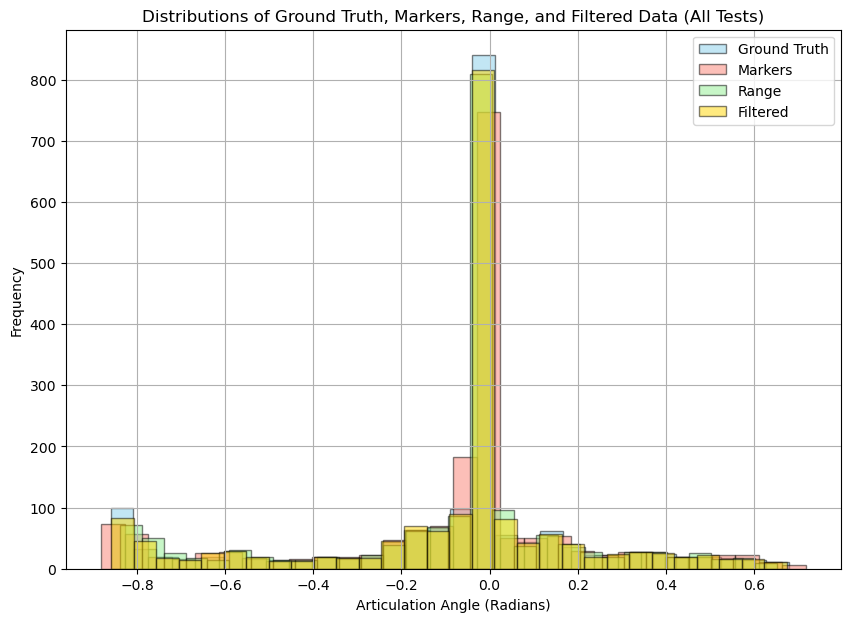

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store data from all tests
all_data = []

# Define the number of scenarios and tests
scenario = 1  # Update this based on your specific scenarios
num_tests = 5  # Assuming there are 5 tests per scenario

# Loop through each scenario and test, and read the CSV files
for test in range(1, num_tests + 1):
    directory = f'Tests/Scenario {scenario}/Test{test}/'
    file_path = os.path.join(directory, 'aggregated_data.csv')
    
    # Read the CSV file
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        all_data.append(data)

# Concatenate all the data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Prepare histograms for all methods: ground truth, marker, range, and filtered
plt.figure(figsize=(10, 7))
# Set alpha for transparency so that overlapping areas are visible
plt.hist(combined_data['ground_truth'], bins=30, alpha=0.5, label='Ground Truth', color='skyblue', edgecolor='black')
plt.hist(combined_data['markers'], bins=30, alpha=0.5, label='Markers', color='salmon', edgecolor='black')
plt.hist(combined_data['range'], bins=30, alpha=0.5, label='Range', color='lightgreen', edgecolor='black')
plt.hist(combined_data['filtered'], bins=30, alpha=0.5, label='Filtered', color='gold', edgecolor='black')

plt.title('Distributions of Ground Truth, Markers, Range, and Filtered Data (All Tests)')
plt.xlabel('Articulation Angle (Radians)')
plt.ylabel('Frequency')
plt.legend()  # Add a legend to help identify the histograms
plt.grid(True)

# Save and show the plot
plt.savefig(f'Tests/Scenario 1/SC1_histograms_overlap.png', format='png')  # Ensure the directory exists or handle directory creation
plt.show()


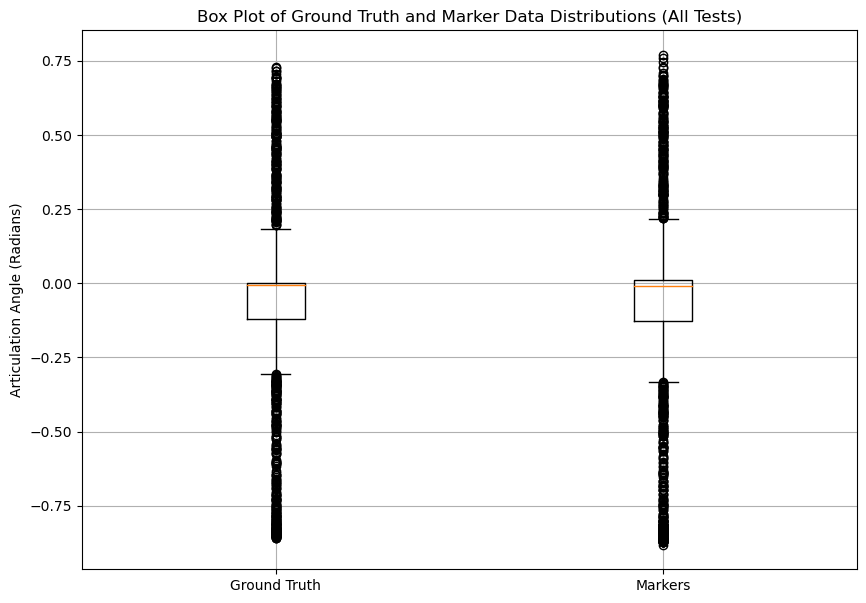

In [21]:
# Initialize an empty list to store data from all tests
all_data = []

# Define the number of scenarios and tests
scenario = 3  # Update this based on your specific scenarios
num_tests = 5  # Assuming there are 5 tests per scenario

# Loop through each scenario and test, and read the CSV files

for test in range(1, num_tests + 1):
    directory = f'Tests/Scenario {scenario}/Test{test}/'
    file_path = os.path.join(directory, 'aggregated_data.csv')
    
    # Read the CSV file
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        all_data.append(data)

# Concatenate all the data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Prepare the box plot for all methods: ground truth, marker, range, and filtered
plt.figure(figsize=(10, 7))
plt.boxplot([combined_data['ground_truth'], combined_data['markers']], 
            labels=['Ground Truth', 'Markers'])

plt.title('Box Plot of Ground Truth and Marker Data Distributions (All Tests)')
plt.ylabel('Articulation Angle (Radians)')
plt.grid(True)
plt.show()